In [2]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [3]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [4]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh
from tqdm.autonotebook import tqdm
from pytorch3d.io import save_obj
import pandas as pd

import postprocess_dataset
from utils import utils, visualization_tools, nn_pose_est, eval_utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1, sample_points
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist
from mesh_refiner import MeshRefiner

In [15]:
# shapenet
dataset_type = "shapenet"
class_name = "03211117"
input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_name)
input_img_dir = "data/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
gt_shapes_list_path = "data/gt_shapes_path_lists/shapenet_{}_gt_shapes.lst".format(class_name)

# pix3d
#dataset_type = "pix3d"
#class_name = "chair"
#input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pix3d/{}/generation/meshes".format(class_name)
#input_img_dir = "data/pix3d_images_processed_filtered/{}/rgba".format(class_name)
#gt_shapes_list_path = "data/gt_shapes_path_lists/pix3d_{}_gt_shapes.lst".format(class_name)

In [16]:
cfg_path = "configs/final_refinement_params.yaml"

device = torch.device("cuda:0")
cfg = utils.load_config(cfg_path, "configs/default.yaml")
gt_shapes_dict = {}
with open(gt_shapes_list_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]
pose_dict = pickle.load(open(os.path.join(input_img_dir, "renders_camera_params.pt"), "rb"))
instances = [str(path).split('/')[-1].replace(".obj", "") for path in list(Path(input_mesh_dir).rglob("*.obj"))]

#instances = ['2394', '1517', '0191', '1598']
instances = instances[:20]
print(instances)
print(cfg)

['ea4b90cca359e2d38b9be827bf6fc77', 'f800fbcdef1ac9038b5dbcd4be5ceef8', 'd85f501bf76933c609d7d8d27dbba7f', 'f240248beae8d20661049a5d9182333f', 'decec5d8e1f9f54e1a5295d0078b5d60', 'f47044b611046a7bf901627f525bf7a', 'fac8bc5420f9d472b36c473722d8f02c', 'f75d1962eb04669a164790a64bab08f0', 'f5b05e9eedcbaf9cf4d1910799b338b7', 'd7ab9503d7f6dac6b4382097c3e8bcf7', 'dada218e78c9c81e2250bf58700b4d8f', 'dbcd5a88a9d4f1d7579cfe4420588034', 'f5f5e872bf70f59983f551e0fd7d32ac', 'f3bfeab806cc976072052f2ed83934f0', 'df8e098d4dbcb5b2ccc4d915989bc424', 'e1eac12837bcadcf44d2fe7d13c65f0c', 'ffc224f284b63b17b0f6d70666df2668', 'd9bac9c418667d2ba62bc668cb34e698', 'e2787b2f0dd35fccf42a90fe4baf4591', 'df35d335e76abf5618ba239e198ef2ba']
{'dataset': {'input_dir_mesh': 'data/onet_chair_shapent_no_DA_simplified', 'input_dir_img': 'data/img_shapenet_chair', 'gt_shapes_lst_path': 'data/gt_shapes_path_lists/shapenet_chair_gt_shapes.lst'}, 'brute_force_pose_est': {'num_azims': 20, 'num_elevs': 20, 'num_dists': 40}, 'mode

ea4b90cca359e2d38b9be827bf6fc77
1.1410256624221802 40.0 125.31018829345703 gt
Input mesh metrics: {'2d_iou_multi': 0.8276478995879492, '2d_iou_input': 0.8704562783241272, '3d_iou': 0.67677915, 'chamfer_L1': 0.0003786861780099571, 'chamfer_L1_uniformly': 0.0003552832640707493}



Refined mesh metrics: {'2d_iou_multi': 0.8856577624877294, '2d_iou_input': 0.9738839864730835, '3d_iou': 0.8071646, 'chamfer_L1': 0.00013293049414642155, 'chamfer_L1_uniformly': 0.0002593450481072068}


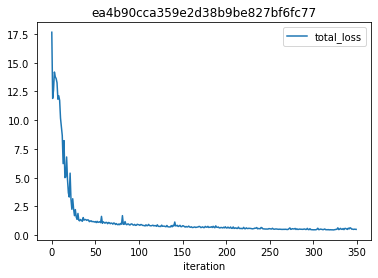

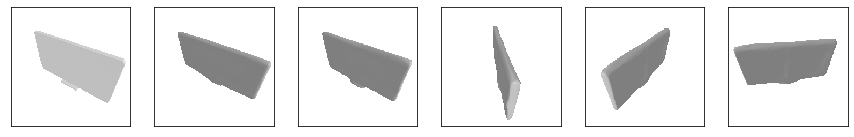

f800fbcdef1ac9038b5dbcd4be5ceef8
1.1410256624221802 40.0 265.372802734375 gt
Input mesh metrics: {'2d_iou_multi': 0.7082949914038181, '2d_iou_input': 0.7661294937133789, '3d_iou': 0.2581026, 'chamfer_L1': 0.001452900469303131, 'chamfer_L1_uniformly': 0.0011899120872840285}



Refined mesh metrics: {'2d_iou_multi': 0.751689001917839, '2d_iou_input': 0.9598551988601685, '3d_iou': 0.26943004, 'chamfer_L1': 0.001757376710884273, 'chamfer_L1_uniformly': 0.0013144321274012327}


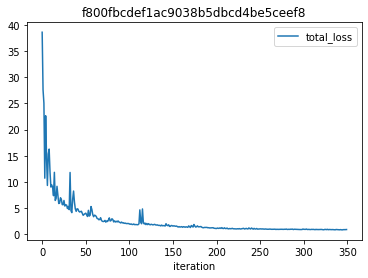

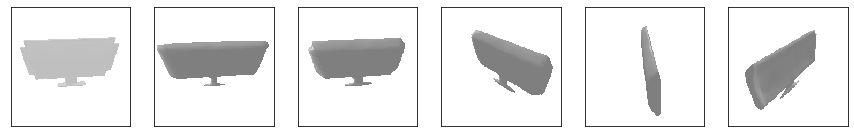

d85f501bf76933c609d7d8d27dbba7f
1.2051281929016113 40.0 222.77224731445312 gt
Input mesh metrics: {'2d_iou_multi': 0.6845582537353039, '2d_iou_input': 0.6829615235328674, '3d_iou': 0.05514624, 'chamfer_L1': 0.005454189609736204, 'chamfer_L1_uniformly': 0.005788937211036682}



Refined mesh metrics: {'2d_iou_multi': 0.7841439694166183, '2d_iou_input': 0.9101290702819824, '3d_iou': 0.3, 'chamfer_L1': 0.0018284933175891638, 'chamfer_L1_uniformly': 0.001888674683868885}


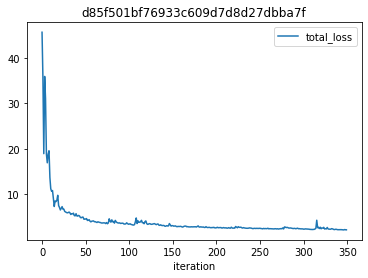

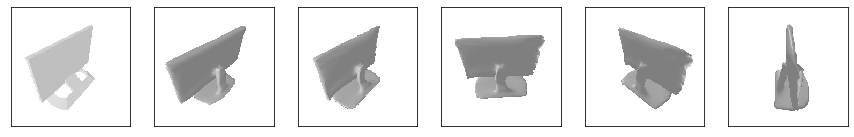

f240248beae8d20661049a5d9182333f
1.0769230127334595 40.0 322.0618591308594 gt
Input mesh metrics: {'2d_iou_multi': 0.7611723939577738, '2d_iou_input': 0.7700902223587036, '3d_iou': 0.48963907, 'chamfer_L1': 0.0010857313172891736, 'chamfer_L1_uniformly': 0.0007435409352183342}



Refined mesh metrics: {'2d_iou_multi': 0.8499726951122284, '2d_iou_input': 0.9534410238265991, '3d_iou': 0.5953677, 'chamfer_L1': 0.00042488102917559445, 'chamfer_L1_uniformly': 0.0003639904607553035}


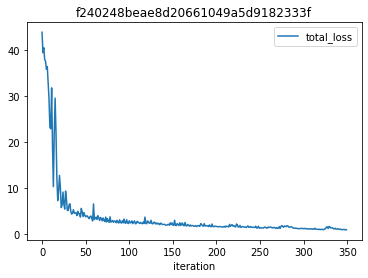

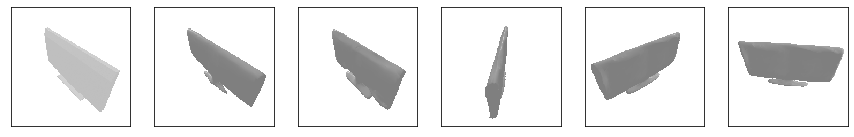

decec5d8e1f9f54e1a5295d0078b5d60
1.2051281929016113 40.0 55.893245697021484 gt
Input mesh metrics: {'2d_iou_multi': 0.7724624648690224, '2d_iou_input': 0.9404927492141724, '3d_iou': 0.49976555, 'chamfer_L1': 0.0003474914119578898, 'chamfer_L1_uniformly': 0.00034948522807098925}



Refined mesh metrics: {'2d_iou_multi': 0.7745391515394052, '2d_iou_input': 0.9843059778213501, '3d_iou': 0.50413316, 'chamfer_L1': 0.00035793622373603284, 'chamfer_L1_uniformly': 0.00037789641646668315}


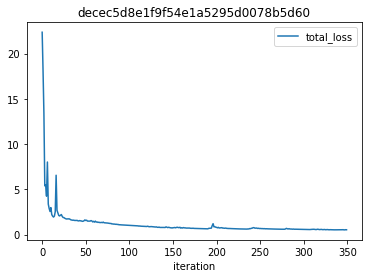

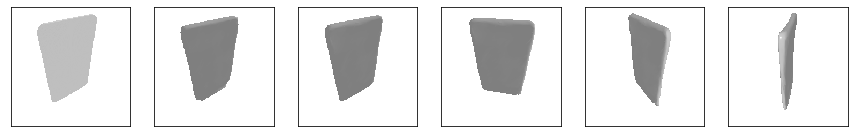

f47044b611046a7bf901627f525bf7a
1.2051281929016113 40.0 52.24284362792969 gt
Input mesh metrics: {'2d_iou_multi': 0.6107156341895461, '2d_iou_input': 0.7932102680206299, '3d_iou': 0.0076154214, 'chamfer_L1': 0.0011755605228245258, 'chamfer_L1_uniformly': 0.016408048570156097}



Refined mesh metrics: {'2d_iou_multi': 0.6445910486703118, '2d_iou_input': 0.8457079529762268, '3d_iou': 0.00040887253, 'chamfer_L1': 0.0019501864444464445, 'chamfer_L1_uniformly': 0.00902916956692934}


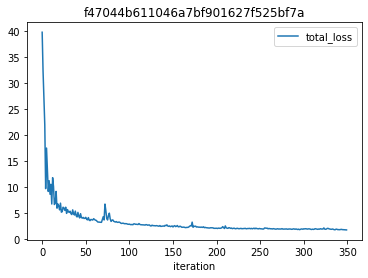

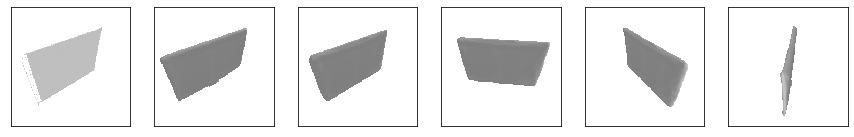

fac8bc5420f9d472b36c473722d8f02c
1.3333332538604736 40.0 57.96144104003906 gt
Input mesh metrics: {'2d_iou_multi': 0.6264784249166647, '2d_iou_input': 0.7882797122001648, '3d_iou': 0.0511605, 'chamfer_L1': 0.009790358133614063, 'chamfer_L1_uniformly': 0.010284791700541973}



Refined mesh metrics: {'2d_iou_multi': 0.6814993980030218, '2d_iou_input': 0.9057541489601135, '3d_iou': 0.06916903, 'chamfer_L1': 0.0043698521330952644, 'chamfer_L1_uniformly': 0.005117328837513924}


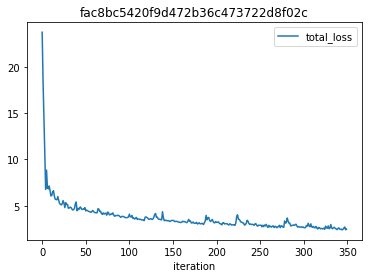

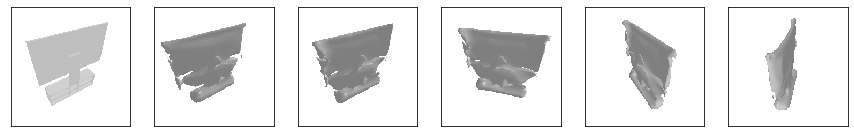

f75d1962eb04669a164790a64bab08f0
1.2692307233810425 40.0 20.2822208404541 gt
Input mesh metrics: {'2d_iou_multi': 0.8073214441537857, '2d_iou_input': 0.8653112053871155, '3d_iou': 0.6381468, 'chamfer_L1': 0.003274244721978903, 'chamfer_L1_uniformly': 0.0009247856214642525}



Refined mesh metrics: {'2d_iou_multi': 0.8040770118435224, '2d_iou_input': 0.9562119841575623, '3d_iou': 0.6375165, 'chamfer_L1': 0.0031782081350684166, 'chamfer_L1_uniformly': 0.0008854392799548805}


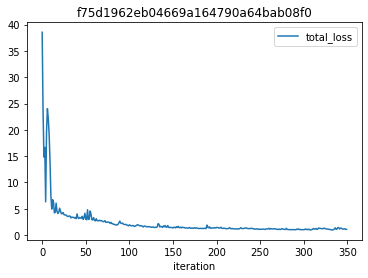

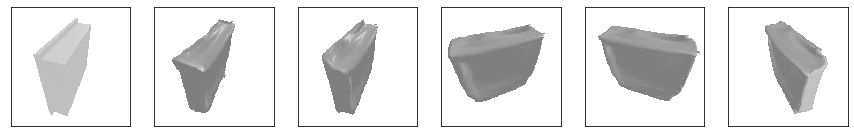

f5b05e9eedcbaf9cf4d1910799b338b7
1.1410256624221802 40.0 303.9944152832031 gt
Input mesh metrics: {'2d_iou_multi': 0.8289436002572378, '2d_iou_input': 0.8628115653991699, '3d_iou': 0.61919487, 'chamfer_L1': 0.0010747585911303759, 'chamfer_L1_uniformly': 0.0005047334125265479}



Refined mesh metrics: {'2d_iou_multi': 0.8646257941921552, '2d_iou_input': 0.9644013047218323, '3d_iou': 0.6178521, 'chamfer_L1': 0.0010778012219816446, 'chamfer_L1_uniformly': 0.0005097308894619346}


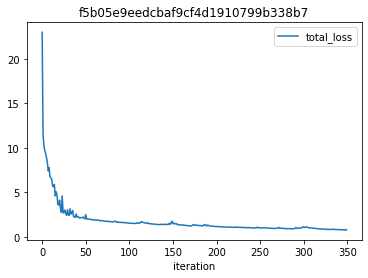

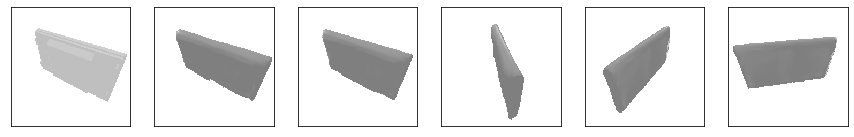

d7ab9503d7f6dac6b4382097c3e8bcf7
1.1410256624221802 40.0 254.95828247070312 gt
Input mesh metrics: {'2d_iou_multi': 0.8315021271506945, '2d_iou_input': 0.9169397354125977, '3d_iou': 0.339658, 'chamfer_L1': 0.0012466850457713008, 'chamfer_L1_uniformly': 0.0006924610352143645}



Refined mesh metrics: {'2d_iou_multi': 0.8538611109058062, '2d_iou_input': 0.9705259799957275, '3d_iou': 0.6173793, 'chamfer_L1': 0.0003333787608426064, 'chamfer_L1_uniformly': 0.0003311558975838125}


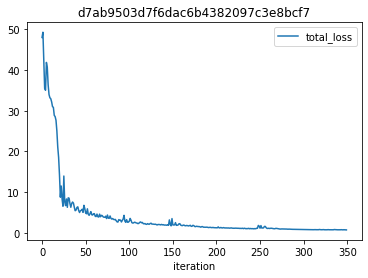

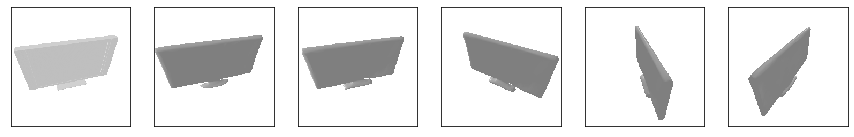

dada218e78c9c81e2250bf58700b4d8f
1.1410256624221802 40.0 188.84603881835938 gt
Input mesh metrics: {'2d_iou_multi': 0.15318009288360676, '2d_iou_input': 0.11213099956512451, '3d_iou': 0.0009881423, 'chamfer_L1': 0.16872721910476685, 'chamfer_L1_uniformly': 0.19425997138023376}



Refined mesh metrics: {'2d_iou_multi': 0.17695971578359604, '2d_iou_input': 0.19337067008018494, '3d_iou': 0.014181349, 'chamfer_L1': 0.11728766560554504, 'chamfer_L1_uniformly': 0.10909369587898254}


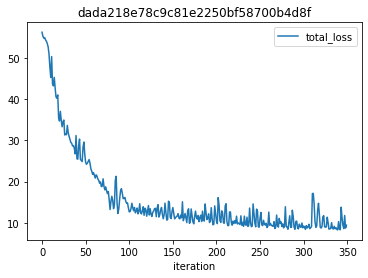

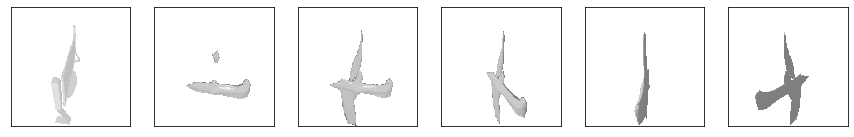

dbcd5a88a9d4f1d7579cfe4420588034
1.4615384340286255 40.0 154.3732147216797 gt
Input mesh metrics: {'2d_iou_multi': 0.6955512041846911, '2d_iou_input': 0.8549615144729614, '3d_iou': 0.16120172, 'chamfer_L1': 0.009143286384642124, 'chamfer_L1_uniformly': 0.008160530589520931}



Refined mesh metrics: {'2d_iou_multi': 0.7157273987929026, '2d_iou_input': 0.9606006145477295, '3d_iou': 0.3097712, 'chamfer_L1': 0.0021825511939823627, 'chamfer_L1_uniformly': 0.001838037627749145}


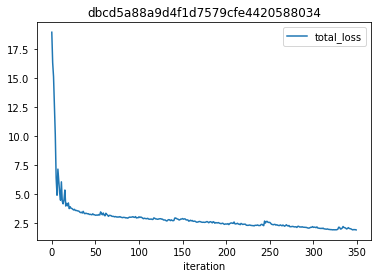

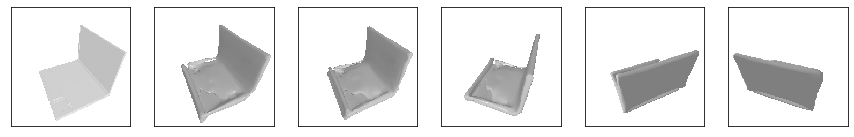

f5f5e872bf70f59983f551e0fd7d32ac
1.2051281929016113 40.0 142.28408813476562 gt
Input mesh metrics: {'2d_iou_multi': 0.7091161782542864, '2d_iou_input': 0.7512315511703491, '3d_iou': 0.3216802, 'chamfer_L1': 0.0026132408529520035, 'chamfer_L1_uniformly': 0.006442431826144457}



Refined mesh metrics: {'2d_iou_multi': 0.761447204897801, '2d_iou_input': 0.9147428870201111, '3d_iou': 0.0048812237, 'chamfer_L1': 0.0025700286496430635, 'chamfer_L1_uniformly': 0.01621023751795292}


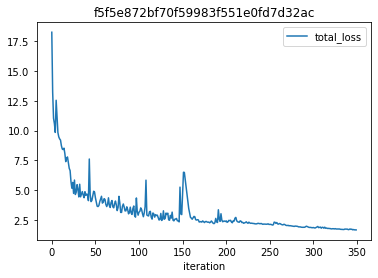

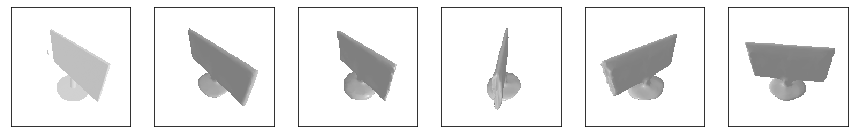

f3bfeab806cc976072052f2ed83934f0
1.2051281929016113 40.0 32.54616165161133 gt
Input mesh metrics: {'2d_iou_multi': 0.7361617336670557, '2d_iou_input': 0.8622651100158691, '3d_iou': 0.42224798, 'chamfer_L1': 0.00456312857568264, 'chamfer_L1_uniformly': 0.0014951119665056467}



Refined mesh metrics: {'2d_iou_multi': 0.7663859898845354, '2d_iou_input': 0.970250129699707, '3d_iou': 0.38343093, 'chamfer_L1': 0.004357434809207916, 'chamfer_L1_uniformly': 0.0011908437591046095}


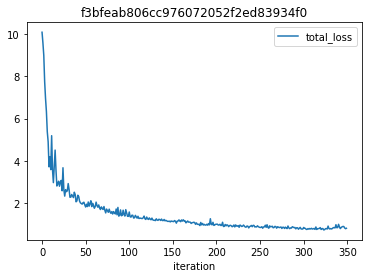

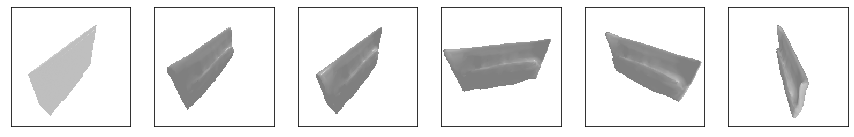

df8e098d4dbcb5b2ccc4d915989bc424
1.2051281929016113 40.0 297.336669921875 gt
Input mesh metrics: {'2d_iou_multi': 0.7672034415105978, '2d_iou_input': 0.7913640141487122, '3d_iou': 0.23015477, 'chamfer_L1': 0.0020185154862701893, 'chamfer_L1_uniformly': 0.0016555226175114512}



Refined mesh metrics: {'2d_iou_multi': 0.8527862057089806, '2d_iou_input': 0.9646182656288147, '3d_iou': 0.5319338, 'chamfer_L1': 0.0006920069572515786, 'chamfer_L1_uniformly': 0.0006503990734927356}


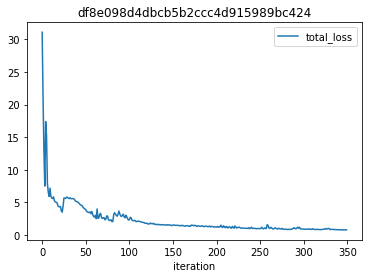

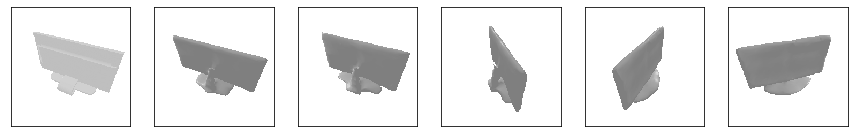

e1eac12837bcadcf44d2fe7d13c65f0c
1.2051281929016113 40.0 15.35169792175293 gt
Input mesh metrics: {'2d_iou_multi': 0.8632424945632616, '2d_iou_input': 0.8746057748794556, '3d_iou': 0.4868184, 'chamfer_L1': 0.000932411989197135, 'chamfer_L1_uniformly': 0.000537724350579083}



Refined mesh metrics: {'2d_iou_multi': 0.877458301683267, '2d_iou_input': 0.9332135319709778, '3d_iou': 0.6496416, 'chamfer_L1': 0.0003226055996492505, 'chamfer_L1_uniformly': 0.00035984572605229914}


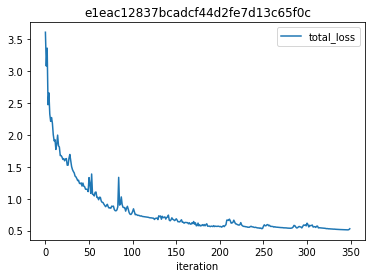

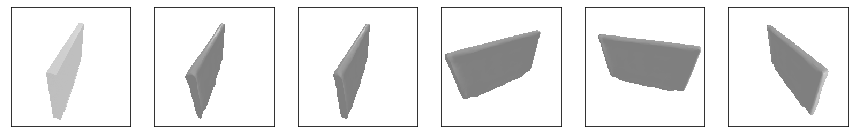

ffc224f284b63b17b0f6d70666df2668
1.2692307233810425 40.0 48.789981842041016 gt
Input mesh metrics: {'2d_iou_multi': 0.7420727225641409, '2d_iou_input': 0.9176602959632874, '3d_iou': 0.3032142, 'chamfer_L1': 0.00218728045001626, 'chamfer_L1_uniformly': 0.0014427471905946732}



Refined mesh metrics: {'2d_iou_multi': 0.7766109382112821, '2d_iou_input': 0.960104763507843, '3d_iou': 0.42970347, 'chamfer_L1': 0.0014352506259456277, 'chamfer_L1_uniformly': 0.0011930516920983791}


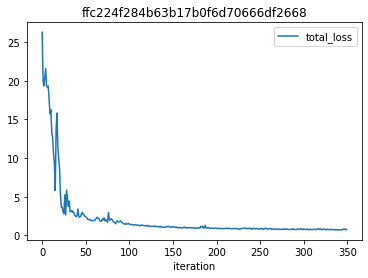

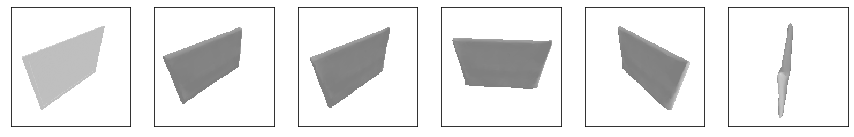

d9bac9c418667d2ba62bc668cb34e698
1.2051281929016113 40.0 298.6354064941406 gt
Input mesh metrics: {'2d_iou_multi': 0.6729014168183008, '2d_iou_input': 0.880706250667572, '3d_iou': 0.0018976772, 'chamfer_L1': 0.0018396663945168257, 'chamfer_L1_uniformly': 0.9202864766120911}



Refined mesh metrics: {'2d_iou_multi': 0.715372504045566, '2d_iou_input': 0.9820787310600281, '3d_iou': 0.0016120712, 'chamfer_L1': 0.0020490488968789577, 'chamfer_L1_uniformly': 0.8661970496177673}


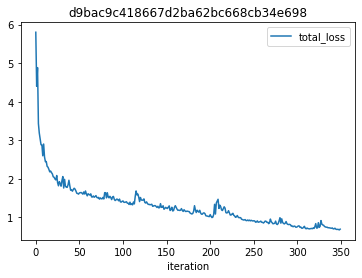

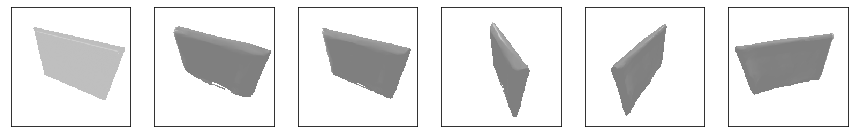

e2787b2f0dd35fccf42a90fe4baf4591
1.2051281929016113 40.0 15.508768081665039 gt
Input mesh metrics: {'2d_iou_multi': 0.8249988208214442, '2d_iou_input': 0.8459060192108154, '3d_iou': 0.74064994, 'chamfer_L1': 0.002043207408860326, 'chamfer_L1_uniformly': 0.0008988910121843219}



Refined mesh metrics: {'2d_iou_multi': 0.8162967388828596, '2d_iou_input': 0.9274866580963135, '3d_iou': 0.71988964, 'chamfer_L1': 0.002181167248636484, 'chamfer_L1_uniformly': 0.0009726577554829419}


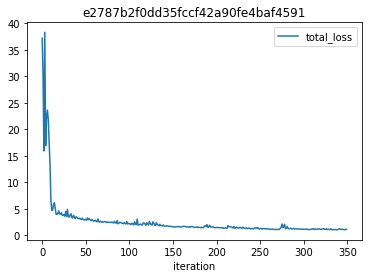

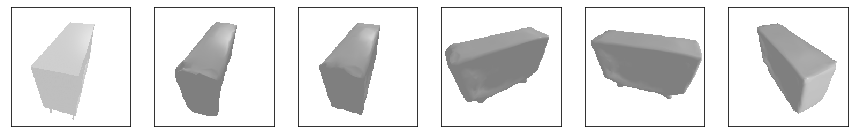

df35d335e76abf5618ba239e198ef2ba
1.1410256624221802 40.0 270.61700439453125 gt
Input mesh metrics: {'2d_iou_multi': 0.5983617547899485, '2d_iou_input': 0.7350977659225464, '3d_iou': 0.054979153, 'chamfer_L1': 0.005359193775802851, 'chamfer_L1_uniformly': 0.005948249250650406}



Refined mesh metrics: {'2d_iou_multi': 0.6177852905044953, '2d_iou_input': 0.8257209062576294, '3d_iou': 0.06163772, 'chamfer_L1': 0.0027280517388135195, 'chamfer_L1_uniformly': 0.002681029262021184}


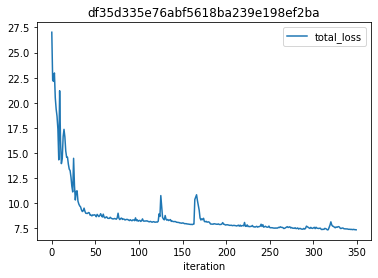

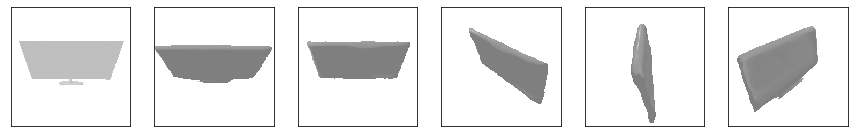

In [17]:
num_azims=20
num_elevs=20
num_dists=40

pose_settings=["gt"]
show_metrics = True

results_df = pd.DataFrame()
for instance in instances:
    print(instance)
    input_img_path = os.path.join(input_img_dir,"{}.png".format(instance))
    input_image = np.asarray(Image.open(input_img_path))
    input_mesh_path = os.path.join(input_mesh_dir,"{}.obj".format(instance))
    gt_mesh_path = gt_shapes_dict[instance.split("_")[0]]
    with torch.no_grad():
        input_mesh = utils.load_untextured_mesh(input_mesh_path, device)
        gt_mesh = utils.load_untextured_mesh(gt_mesh_path, device)
    input_trimesh= trimesh.load(input_mesh_path)
    gt_trimesh = trimesh.load(gt_mesh_path)
    mask = np.asarray(input_image)[:,:,3] > 0
    
    instance_info = {"instance": instance}
    
    pose_info_list = []
    if "gt" in pose_settings:
        gt_elev = pose_dict[instance]["elev"]
        gt_azim = pose_dict[instance]["azim"]
        #gt_dist = pose_dict[instance]["dist"]
        _, _, gt_dist, _, _ = brute_force_estimate_dist(input_mesh, mask, gt_azim, gt_elev, num_dists, device)
        pose_info_list.append([gt_dist.item(), gt_elev, gt_azim, "gt"])
    if "bf" in pose_settings:
        bf_pred_azim, bf_pred_elev, bf_pred_dist, _, _ = brute_force_estimate_pose(input_mesh, mask, num_azims, num_elevs, num_dists, device)
        pose_info_list.append([bf_pred_dist.item(), bf_pred_elev.item(), bf_pred_azim.item(), "bf"])
        
    for (dist, elev, azim, name) in pose_info_list:
        #if dataset_type == "pix3d":
        #    azim = azim - 90
        #dist = float(dist)
        #elev = float(elev)
        #azim = float(azim)
        print(dist, elev, azim, name)
        if show_metrics:
            input_metrics_dict, input_debug_dict = eval_utils.eval_metrics(input_image, input_trimesh, input_mesh, gt_trimesh, 
                                                                           gt_mesh, device, metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1", "chamfer_L1_uniformly"],
                                                                           pred_azim=azim, pred_elev=elev, pred_dist=dist)
            instance_info = {**instance_info, **{"original_{}_{}".format(name, metric):input_metrics_dict[metric] for metric in input_metrics_dict}}
            print("Input mesh metrics: {}".format(input_metrics_dict))
        
        
        
        mesh_refiner = MeshRefiner(cfg, device)
        refined_mesh, loss_info = mesh_refiner.refine_mesh(input_mesh, input_image, dist, elev, azim)
        refined_mesh_path = os.path.join("notebooks/out", "{}_{}.obj".format(instance, name))
        save_obj(refined_mesh_path, refined_mesh.verts_packed(), refined_mesh.faces_packed())
        refined_trimesh = trimesh.load(refined_mesh_path)
        refined_mesh = utils.load_untextured_mesh(refined_mesh_path, device)
        if show_metrics:
            refined_metrics_dict, refined_debug_dict = eval_utils.eval_metrics(input_image, refined_trimesh, refined_mesh, gt_trimesh, gt_mesh, device, 
                                                                          metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1", "chamfer_L1_uniformly"],
                                                                          pred_azim=azim, pred_elev=elev, pred_dist=dist)
            print("Refined mesh metrics: {}".format(refined_metrics_dict))
            instance_info = {**instance_info, **{"refined_{}_{}".format(name, metric):refined_metrics_dict[metric] for metric in refined_metrics_dict}}

        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance))
        visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, dist, elev, azim, device)
    
    results_df = results_df.append(instance_info, ignore_index=True)
    print("=========================================================================================")


In [1]:
display(results_df)
print(results_df.mean())

NameError: name 'results_df' is not defined